In [1]:
import librosa
import numpy
import pandas
import requests
import seaborn
import sklearn
import tensorflow

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

In [2]:
# Get list of all recordings
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"]
    })

dataframe = pandas.json_normalize(recordings)

dataframe.head()

,path,label,environment
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg


In [3]:
dataframe = dataframe[dataframe["environment"] == "marsberg"]

In [4]:
# Generate MFCCs for each recording
def preprocess(dataframe):
    features = []
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate)
        features.append(numpy.mean(mfcc.T, axis=0))
        
    dataframe["features"] = features
    
    return dataframe

dataframe = preprocess(dataframe)

71it [01:07,  1.05it/s]


In [5]:
# Prepare and split data for training
x = numpy.array(dataframe["features"].tolist())
y = numpy.array(dataframe["label"].tolist())

x = numpy.expand_dims(x, axis=2)

label_encoder = sklearn.preprocessing.LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.15, random_state=1)
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.15, random_state=1)

print(x_train.shape, x_test.shape, x_val.shape)

(51, 20, 1) (11, 20, 1) (9, 20, 1)


In [6]:
input_shape=(20, 1)
model = keras.Sequential()
model.add(LSTM(200,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train, epochs=75, validation_data=(x_val, y_val), shuffle=False)

2022-09-19 16:50:37.644408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0

In [7]:
test_accuracy=model.evaluate(x_test, y_test, verbose=0)
print(test_accuracy[1])

0.9090909361839294


In [8]:
y_true, y_pred = numpy.argmax(y_test, axis=1), numpy.argmax(model.predict(x_test), axis=1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

confusion_matrix

1/1 [==============================] - 1s 519ms/step


array([[2, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 2]])

In [9]:
def confusion_matrix_table(y_true, y_pred):
    labels = sklearn.utils.multiclass.unique_labels(y_test)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pandas.DataFrame(sklearn.metrics.confusion_matrix(y_true, y_pred), columns=columns, index=index)
    return table

In [10]:
def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0) 
    return plot

<AxesSubplot:>

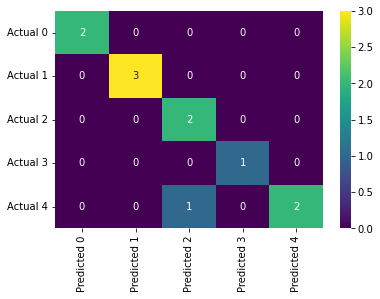

In [11]:
confusion_matrix_plot(y_true, y_pred)